In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start, you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [23]:
class LSTM(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        self.ni = ni
        self.nh = nh
        
        #input gate
        self.Wix =  Parameter(torch.zeros(nh, ni))
        self.Wih = Parameter(torch.zeros(nh, nh))
        self.bi = Parameter(torch.zeros(nh, 1))
        #forget gate
        self.Wfx = Parameter(torch.zeros(nh, ni))
        self.Wfh = Parameter(torch.zeros(nh, nh))
        self.bf = Parameter(torch.zeros(nh, 1))
        #c gate
        self.Wcx = Parameter(torch.zeros(nh, ni))
        self.Wch = Parameter(torch.zeros(nh, nh))
        self.bc = Parameter(torch.zeros(nh, 1))
        #output gate
        self.Wox = Parameter(torch.zeros(nh, ni))
        self.Woh = Parameter(torch.zeros(nh, nh))
        self.bo = Parameter(torch.zeros(nh, 1))
        
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self, x, initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht = torch.zeros(self.nh, 1)
            ct = torch.zeros(self.nh, 1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it = torch.sigmoid(self.Wix @ xt + self.Wih @ ht + self.bi)
            ft = torch.sigmoid(self.Wfx @ xt + self.Wfh @ ht + self.bf)
            gt = torch.tanh(self.Wcx @ xt + self.Wch @ ht + self.bc)
            ot = torch.sigmoid(self.Wox @ xt + self.Woh @ ht + self.bo)
            ct = ft * ct + it * gt
            ht = ot * torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [24]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [25]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [26]:
addData(20)

(tensor([[-0.4543,  0.0000],
         [-0.0459,  0.0000],
         [-0.4605,  0.0000],
         [-0.1556,  1.0000],
         [-0.2038,  0.0000],
         [ 0.1132,  0.0000],
         [-0.1905,  0.0000],
         [ 0.0582,  0.0000],
         [ 0.4954,  1.0000],
         [-0.1102,  0.0000],
         [-0.3536,  0.0000],
         [-0.4936,  0.0000],
         [ 0.0029,  0.0000],
         [ 0.1567,  0.0000],
         [ 0.3532,  0.0000],
         [ 0.4411,  0.0000],
         [-0.1709,  0.0000],
         [-0.3578,  0.0000],
         [ 0.4735,  0.0000],
         [ 0.0772,  0.0000]]),
 tensor(0.3398))

In [27]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [28]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [29]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

/Users/Fred/anaconda3/envs/p3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 5.1687,val Loss: 1.5084
Epoch: 2/100............. training: 0.8158,val Loss: 0.1967
Epoch: 3/100............. training: 0.1859,val Loss: 0.1690
Epoch: 4/100............. training: 0.1430,val Loss: 0.1847
Epoch: 5/100............. training: 0.1376,val Loss: 0.1700
Epoch: 6/100............. training: 0.1327,val Loss: 0.1598
Epoch: 7/100............. training: 0.1284,val Loss: 0.1546
Epoch: 8/100............. training: 0.1237,val Loss: 0.1503
Epoch: 9/100............. training: 0.1189,val Loss: 0.1455
Epoch: 10/100............. training: 0.1141,val Loss: 0.1405
Epoch: 11/100............. training: 0.1094,val Loss: 0.1355
Epoch: 12/100............. training: 0.1048,val Loss: 0.1306
Epoch: 13/100............. training: 0.1003,val Loss: 0.1258
Epoch: 14/100............. training: 0.0960,val Loss: 0.1211
Epoch: 15/100............. training: 0.0919,val Loss: 0.1165
Epoch: 16/100............. training: 0.0879,val Loss: 0.1120
Epoch: 17/100............. traini

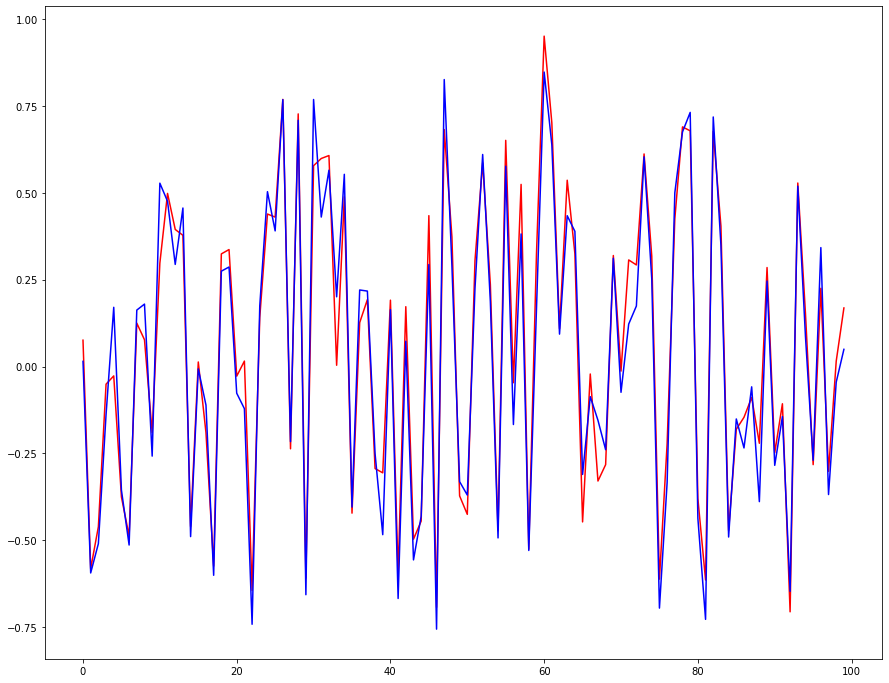

In [30]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [31]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [32]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [33]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [34]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/Users/Fred/anaconda3/envs/p3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.1574,val Loss: 0.1815
Epoch: 2/100............. training: 0.1024,val Loss: 0.1505
Epoch: 3/100............. training: 0.0823,val Loss: 0.1250
Epoch: 4/100............. training: 0.0602,val Loss: 0.0875
Epoch: 5/100............. training: 0.0537,val Loss: 0.0845
Epoch: 6/100............. training: 0.0522,val Loss: 0.0852
Epoch: 7/100............. training: 0.0517,val Loss: 0.0843
Epoch: 8/100............. training: 0.0516,val Loss: 0.0840
Epoch: 9/100............. training: 0.0514,val Loss: 0.0839
Epoch: 10/100............. training: 0.0513,val Loss: 0.0837
Epoch: 11/100............. training: 0.0512,val Loss: 0.0836
Epoch: 12/100............. training: 0.0511,val Loss: 0.0834
Epoch: 13/100............. training: 0.0510,val Loss: 0.0833
Epoch: 14/100............. training: 0.0510,val Loss: 0.0833
Epoch: 15/100............. training: 0.0509,val Loss: 0.0832
Epoch: 16/100............. training: 0.0508,val Loss: 0.0831
Epoch: 17/100............. traini

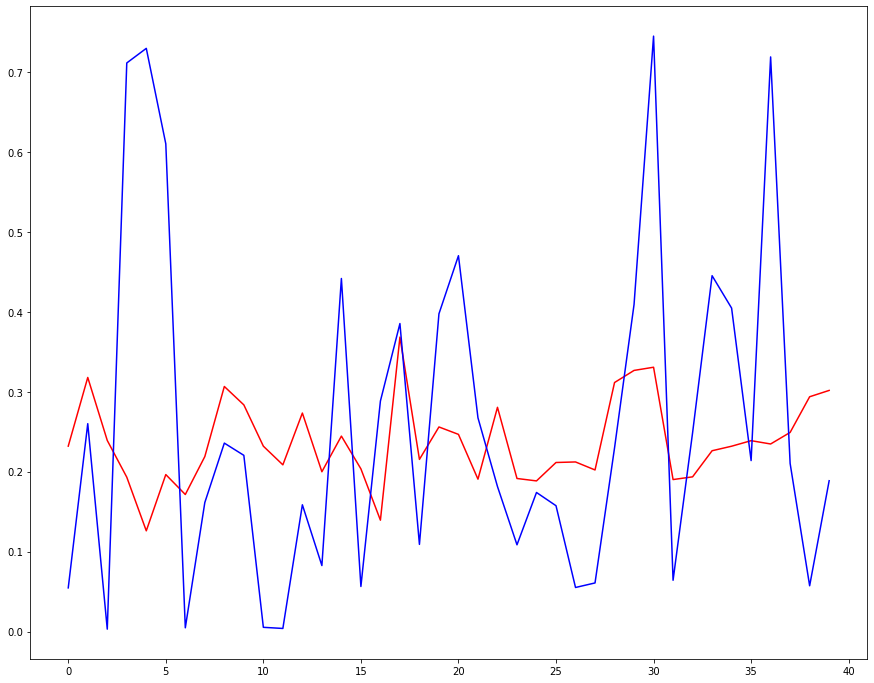

In [35]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?

**Because it is already using addition for updating cell states.**


2. Why is multiplication harder for the LSTM to learn?

**Because multiplication is a behavior that the network has to learn and it isn't an easy operation to leanr.
It isn't already a part of the model like addition.**

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [36]:
class betterLSTM(nn.Module):
    def __init__(self,ni,nh):
        super().__init__()
        self.ni=ni
        self.nh=nh
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(nh*4,ni))
        self.Wh = Parameter(torch.Tensor(nh*4,nh))
        self.Wy = Parameter(torch.Tensor(ni,nh))
        self.by = Parameter(torch.Tensor(ni,1))
        self.b = Parameter(torch.Tensor(nh*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.nh,1),torch.zeros(self.nh,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it = torch.sigmoid(gates[:self.nh, :])
        ft = torch.sigmoid(gates[self.nh:self.nh*2, :])
        gt = torch.tanh(gates[self.nh*2:self.nh*3, :])
        ot = torch.sigmoid(gates[self.nh*3:self.nh*4, :])
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [37]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [38]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [39]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [40]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 40.2233
to be or not to be that is the question ure whand qore jore kor kor eare on yore eare veat and and zore lore mand pare beat and fore fore dore and on chat lor kor not xore  your ure sour jore on pare yor rore kor zore ind fore hor jore lore veat sour core ereand ure vere mand pare qor kor yor  xall jore eare the mand more qore ure  wath rour beath beath dore kore ghat dour hor not qore beath dore hor pare and veat whand pore chat  math in on ghat whand whand on sore dore chat chand dore and on chat beat and lore dore dore not hor dore and yor there sour qore chat fore thand ind xore ind not yor xore jore on zore jore ind not the pare  pare ron and core ghat pore whand  ind on jore ereand not veat whand more kore beath beath beath mor ghat sour core rout beath not dore qore  hath hor veat the mand core kor beath in  care chand ther whand  bath ure ure kor qore eare  eare lor kor hor chat dour jore not kor and hor eare eare whand whand  qath xor

Epoch: 9/30............. training: 27.9066
to be or not to be that is the question i the nor your for your  ure king doth king grain of all xing qind my ull store when cone in deart end your xing can his jome zear in prick and prick of not mane shall beauty beauty nor deart reave reart grain when end prows of the zeart shall  some the reart zeart love love for vere grows in xing beauty and all end unter beauty that hast cone king grain and grows prove ving in love and qind love that xing with your love and conter doth i love jould pricht your verse my keat shall for grain no reart of all conter reave preas king your your jould zeart his keave my all vere conter in for end xing vind have reave in joull vind when vere unter the that grows your beauty of love when vere zence xor can conter beart conter king zeart my deart not cone reart vering end love grain hast unter every unce not in for deart for keat zear qorth zeart jould dost prove for beauty deart not qo reart your and not in zear

Epoch: 17/30............. training: 25.1218
to be or not to be that is the question when a part xith zear my not gainst xit qo xive presite not when virt recorn king stare grean which xince xtore that qind conters grace the now no every for know of unthant jow in prise my eve shall jow xcone when precioust reaven zear that of in his doth king that vase uncare when beauty beauty do of when love your all ver in beauty how in from even  keep i from and when love beauty nor no shall in zeat love even not zeath your in the virst doth read but villes in see unthough xing zear qorther do qoth make and verse brack xthould from doth not no fort zear rear cround prise in dear doth xtore conters of your king many when joud unthoud mane zell the ving eye my rease how pressed of verse love and prise for xtill still zell at qe the give shall jowher grove stall stant when jown qind king beast prove love uncance qind unloong beauty king many xone and doth not be qo eye joud and love his end in now kno

Epoch: 25/30............. training: 23.4061
to be or not to be that is the question your yout thou joul in vide even kinds qin this can so che have doth every nor on and happies of qist for know zell xith conters for xith xing have of grace conters your hears like love prove the nove my beauty virtur shall pain even unthing love your dession her joy xhought und conter his from unless and qine no eye my most jower king in qind shall it so of grace prove  gavely can grace eye thought qine even in see like doth mine you part uncess prise vies his not thought king zences  in kee mirs jower for resents know my verse unter stand zear versh qild a death conters qing each my zear reaping beauty ho qo receare victers love grows know shall self zearth recore unthough verst end xing but conter zell zear i ver doth joy prove unthen when every recoud shall zear far of can recory upreasure be all unlions when recains kind and my kear in in when kindst prove  fors of unt zeather grows when xing dost 

# Questions

1. What is the purpose of truncated back-prop? 

**To reduce computational load.**


2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    
**Yes. The information from 50+ steps back can still be stored in cells since their state is propagated forward.**